In [1]:
import numpy as np
import pandas as pd
from reward_modulators import HomeostaticModulator
from tqdm import trange

def test_homeostatic_modulator_lag(modulator_class, lag=3, setpoint=50, verbose=True):
    np.random.seed(0)
    modulator = modulator_class(setpoint=setpoint, lag=lag)

    # --- Phase 1: Pretrain modulator ---
    for t in trange(10000, desc="Pretraining"):
        reward = np.random.uniform(0, 100)
        modulator.modify_reward(reward, step=-10000 + t)

    # --- Phase 2: Main test sequence with known rewards ---
    rewards = np.linspace(10, 90, 10)
    for step, reward in enumerate(rewards):
        modulator.modify_reward(reward, step=step)

    df = pd.DataFrame(modulator.modulation_history)
    df = df[df["step"] >= 0].reset_index(drop=True)  # Remove pretraining rows
    passed = True

    # --- Test 1: First `lag` modulated rewards should be unmodified ---
    if lag > 0:
        for i in range(lag):
            modulated = df.iloc[i]["modulated_reward"]
            exo = df.iloc[i]["exogenous_reward"]
            if not np.isclose(modulated, exo):
                passed = False
                if verbose:
                    print(f"❌ Step {i}: expected no modulation but got {modulated} (exo={exo})")

    # --- Test 2: Modulated reward should match: exo_applied - modulation_applied ---
    for i in range(lag, len(df)):
        applied_step = df.iloc[i]["applied_step"]
        ref_row = df[df["step"] == applied_step]
        if ref_row.empty:
            if verbose:
                print(f"⚠️ No row found for applied_step={applied_step}")
            continue

        original_exo = ref_row.iloc[0]["exogenous_reward"]
        applied_mod = df.iloc[i]["modulation"]
        expected = original_exo - applied_mod
        actual = df.iloc[i]["modulated_reward"]

        if not np.isclose(expected, actual, atol=1e-4):
            passed = False
            if verbose:
                print(f"❌ Step {i}: expected modulated_reward {expected}, got {actual}")

    # --- Test 3: Check applied_step offset is exactly `step - lag` ---
    for i in range(lag, len(df)):
        if df.iloc[i]["applied_step"] != df.iloc[i]["step"] - lag:
            passed = False
            if verbose:
                print(f"❌ Step {i}: expected applied_step {df.iloc[i]['step'] - lag}, got {df.iloc[i]['applied_step']}")

    if verbose:
        print("✅ All tests passed." if passed else "❌ Some tests failed.")
    return passed

# Usage:
test_homeostatic_modulator_lag(HomeostaticModulator, lag=3, setpoint=50)


Pretraining:   0%|          | 0/10000 [00:00<?, ?it/s]

Pretraining:  23%|██▎       | 2301/10000 [00:00<00:00, 23007.83it/s]

Pretraining:  46%|████▌     | 4602/10000 [00:00<00:00, 22984.72it/s]

Pretraining:  69%|██████▉   | 6901/10000 [00:00<00:00, 22271.59it/s]

Pretraining:  95%|█████████▌| 9507/10000 [00:00<00:00, 23737.39it/s]

Pretraining: 100%|██████████| 10000/10000 [00:00<00:00, 22648.73it/s]

✅ All tests passed.


True

Pretraining:   0%|          | 0/10000 [00:00<?, ?it/s]

Pretraining:  29%|██▊       | 2872/10000 [00:00<00:00, 28706.07it/s]

Pretraining:  57%|█████▋    | 5743/10000 [00:00<00:00, 26256.93it/s]

Pretraining:  91%|█████████ | 9068/10000 [00:00<00:00, 29293.55it/s]

Pretraining: 100%|██████████| 10000/10000 [00:00<00:00, 27550.75it/s]

✅ All tests passed.


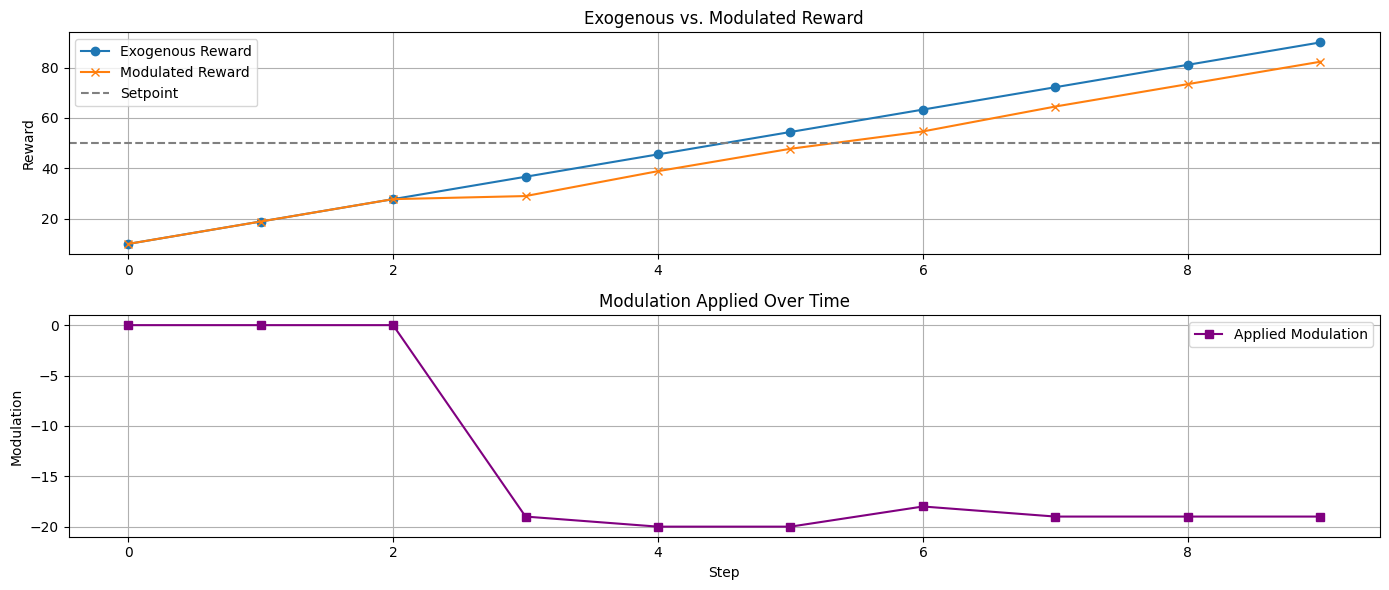

True

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from reward_modulators import HomeostaticModulator
from tqdm import trange

def test_homeostatic_modulator_lag_with_visuals(modulator_class, lag=3, setpoint=50, verbose=True):
    np.random.seed(0)
    modulator = modulator_class(setpoint=setpoint, lag=lag)

    # --- Phase 1: Pretrain modulator ---
    for t in trange(10000, desc="Pretraining"):
        reward = np.random.uniform(0, 100)
        modulator.modify_reward(reward, step=-10000 + t)

    # --- Phase 2: Main test sequence with known rewards ---
    rewards = np.linspace(10, 90, 10)
    for step, reward in enumerate(rewards):
        modulator.modify_reward(reward, step=step)

    # --- Analyze results ---
    df = pd.DataFrame(modulator.modulation_history)
    df = df[df["step"] >= 0].reset_index(drop=True)
    passed = True

    # --- Test 1: No modulation before lag is met ---
    for i in range(lag):
        if not np.isclose(df.loc[i, "modulated_reward"], df.loc[i, "exogenous_reward"]):
            passed = False
            if verbose:
                print(f"❌ Step {i}: expected no modulation, got {df.loc[i, 'modulated_reward']}")

    # --- Test 2: Modulated reward equals exo_applied - modulation_applied ---
    for i in range(lag, len(df)):
        applied_step = df.loc[i, "applied_step"]
        ref_row = df[df["step"] == applied_step]
        if ref_row.empty:
            if verbose:
                print(f"⚠️ Step {i}: no reference for applied_step {applied_step}")
            continue
        original_exo = ref_row.iloc[0]["exogenous_reward"]
        applied_mod = df.loc[i, "modulation"]
        expected = original_exo - applied_mod
        actual = df.loc[i, "modulated_reward"]
        if not np.isclose(expected, actual, atol=1e-4):
            passed = False
            if verbose:
                print(f"❌ Step {i}: expected {expected}, got {actual}")

    # --- Test 3: applied_step is exactly step - lag ---
    for i in range(lag, len(df)):
        expected_applied_step = df.loc[i, "step"] - lag
        if df.loc[i, "applied_step"] != expected_applied_step:
            passed = False
            if verbose:
                print(f"❌ Step {i}: expected applied_step {expected_applied_step}, got {df.loc[i, 'applied_step']}")

    if verbose:
        print("✅ All tests passed." if passed else "❌ Some tests failed.")

    # --- Plotting ---
    plt.figure(figsize=(14, 6))

    # Reward trajectories
    plt.subplot(2, 1, 1)
    plt.plot(df["step"], df["exogenous_reward"], label="Exogenous Reward", marker='o')
    plt.plot(df["step"], df["modulated_reward"], label="Modulated Reward", marker='x')
    plt.axhline(setpoint, color='gray', linestyle='--', label="Setpoint")
    plt.title("Exogenous vs. Modulated Reward")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)

    # Modulation values
    plt.subplot(2, 1, 2)
    plt.plot(df["step"], df["modulation"], label="Applied Modulation", marker='s', color="purple")
    plt.title("Modulation Applied Over Time")
    plt.xlabel("Step")
    plt.ylabel("Modulation")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return passed

# Run it
test_homeostatic_modulator_lag_with_visuals(HomeostaticModulator, lag=3, setpoint=50, verbose=True)
